## Carga de librerías

In [24]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns

## Carga de datos

In [25]:
# Ruta de ubicación de los datos
ruta = os.path.abspath('../data/modelos_entrenamiento/')

# Cargar los datos
X_train = pd.read_csv(os.path.join(ruta, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(ruta, 'y_train.csv')).values.ravel()
X_val = pd.read_csv(os.path.join(ruta, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(ruta, 'y_val.csv')).values.ravel()
X_test = pd.read_csv(os.path.join(ruta, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(ruta, 'y_test.csv')).values.ravel()

## Inicializar el clasificador XG Boost

In [26]:
# Inicializar el clasificador XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Problema de clasificación binaria
    eval_metric='logloss',  # Métrica de evaluación (puede ser logloss para problemas de clasificación binaria)
    use_label_encoder=False,  # Evitar advertencias del uso del codificador de etiquetas obsoleto
    n_estimators=100,  # Número de árboles en el modelo
    learning_rate=0.1,  # Tasa de aprendizaje
    max_depth=6,  # Profundidad máxima de los árboles
    random_state=42  # Para reproducibilidad
)

## Ajustar el modelo con los datos de entrenamiento

In [27]:
# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          #early_stopping_rounds=10,  # Detenerse si la métrica no mejora en 10 iteraciones
          verbose=100)  # Imprimir información cada 100 iteraciones


[0]	validation_0-logloss:0.61077


c:\Users\Administrator\Documents\G1_ML_Airline\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[99]	validation_0-logloss:0.10071


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Calcular métricas de evaluación

In [28]:
# Predicciones en cada conjunto de datos
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Obtener probabilidades para el AUC
y_train_proba = model.predict_proba(X_train)[:, 1]
y_val_proba = model.predict_proba(X_val)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# Métricas para el conjunto de entrenamiento
print("\n### Métricas de Entrenamiento ###")
print("ROC AUC Score en el set de entrenamiento:", roc_auc_score(y_train, y_train_proba))
print("Reporte de clasificación para entrenamiento:\n", classification_report(y_train, y_train_pred))

# Métricas para el conjunto de validación
print("\n### Métricas de Validación ###")
print("ROC AUC Score en el set de validación:", roc_auc_score(y_val, y_val_proba))
print("Reporte de clasificación para validación:\n", classification_report(y_val, y_val_pred))

# Métricas para el conjunto de prueba
print("\n### Métricas de Prueba ###")
print("ROC AUC Score en el set de prueba:", roc_auc_score(y_test, y_test_proba))
print("Reporte de clasificación para prueba:\n", classification_report(y_test, y_test_pred))


### Métricas de Entrenamiento ###
ROC AUC Score en el set de entrenamiento: 0.9955287877187722
Reporte de clasificación para entrenamiento:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     35261
           1       0.97      0.94      0.96     26895

    accuracy                           0.97     62156
   macro avg       0.97      0.96      0.96     62156
weighted avg       0.97      0.97      0.97     62156


### Métricas de Validación ###
ROC AUC Score en el set de validación: 0.9934884448297108
Reporte de clasificación para validación:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     11781
           1       0.97      0.93      0.95      8938

    accuracy                           0.96     20719
   macro avg       0.96      0.96      0.96     20719
weighted avg       0.96      0.96      0.96     20719


### Métricas de Prueba ###
ROC AUC Score en el set de prueba: 0.994109

## Matriz de confusión

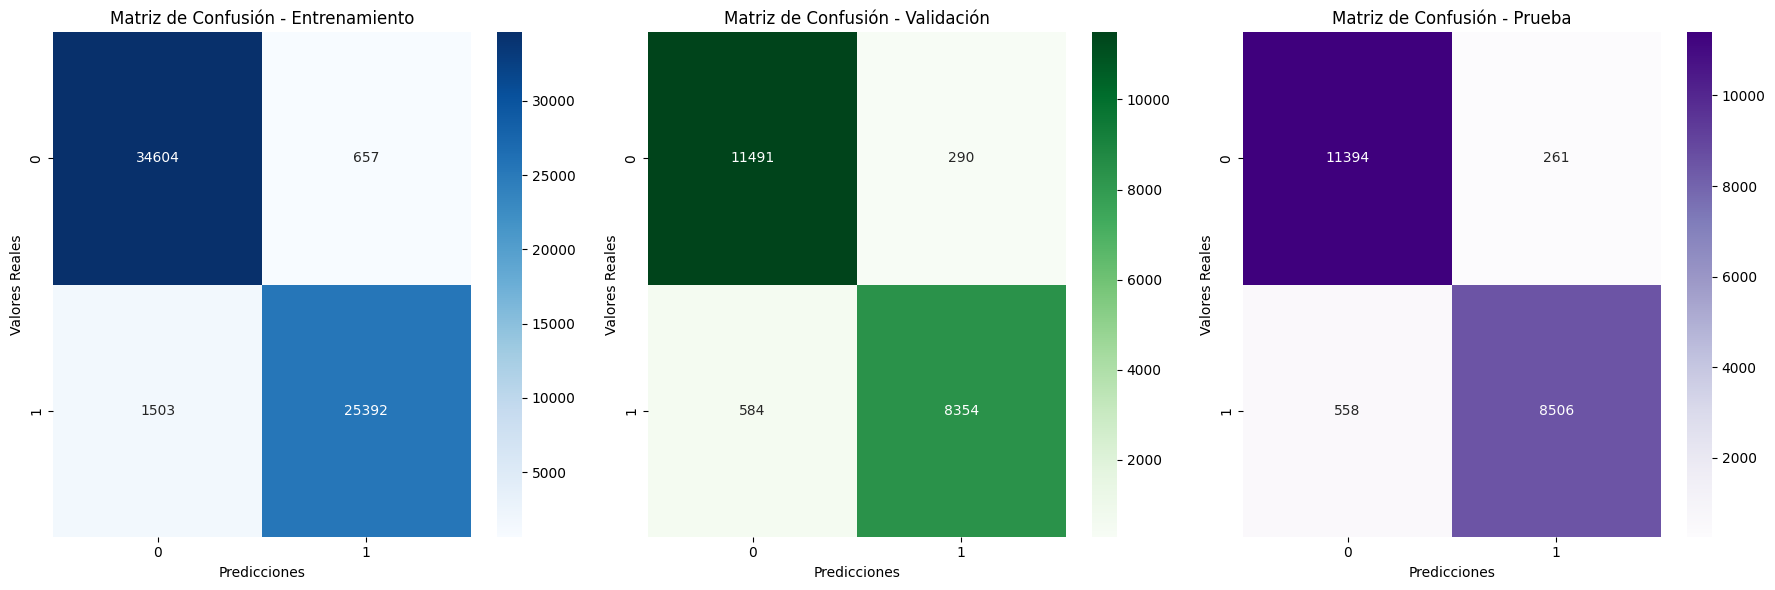

In [29]:
# Calcular las matrices de confusión
cm_train = confusion_matrix(y_train, y_train_pred)
cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Crear una figura con subplots para las tres matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Gráfico para la matriz de confusión de entrenamiento
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Matriz de Confusión - Entrenamiento')
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Valores Reales')

# Gráfico para la matriz de confusión de validación
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title('Matriz de Confusión - Validación')
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Valores Reales')

# Gráfico para la matriz de confusión de prueba
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Purples", ax=axes[2])
axes[2].set_title('Matriz de Confusión - Prueba')
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Valores Reales')

# Ajustar el layout para evitar superposiciones
plt.tight_layout()

# Mostrar la gráfica
plt.show()


## Curva ROC y AUC

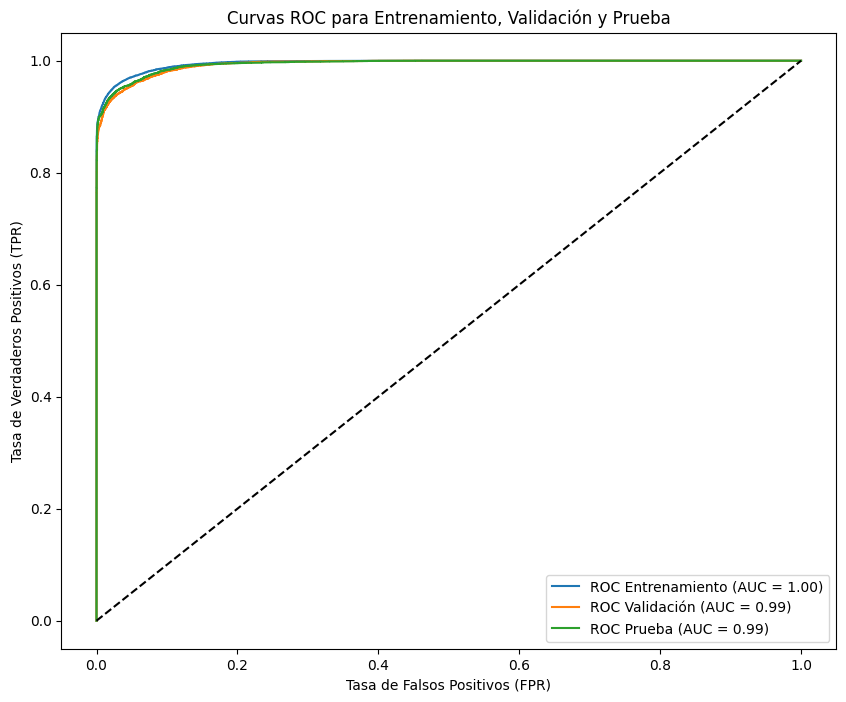

In [30]:

# Calcular los puntos de la curva ROC para cada conjunto de datos
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Calcular el AUC para cada conjunto de datos
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

# Visualizar las curvas ROC
plt.figure(figsize=(10, 8))

# Curva ROC para Entrenamiento
plt.plot(fpr_train, tpr_train, label=f'ROC Entrenamiento (AUC = {roc_auc_train:.2f})')

# Curva ROC para Validación
plt.plot(fpr_val, tpr_val, label=f'ROC Validación (AUC = {roc_auc_val:.2f})')

# Curva ROC para Prueba
plt.plot(fpr_test, tpr_test, label=f'ROC Prueba (AUC = {roc_auc_test:.2f})')

# Línea diagonal de referencia
plt.plot([0, 1], [0, 1], 'k--')

# Etiquetas y título
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para Entrenamiento, Validación y Prueba')
plt.legend(loc='lower right')

# Mostrar la gráfica
plt.show()


## Obtener la importancia de las variables

In [31]:
# Obtener la importancia de las características
importancia_caracteristicas = model.feature_importances_

# Crear un DataFrame para mostrar la importancia con los nombres de las características
importancia_df = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': importancia_caracteristicas
})

# Ordenar el DataFrame por la importancia de las características (de mayor a menor)
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)




## Visualizar la importancia de las variables

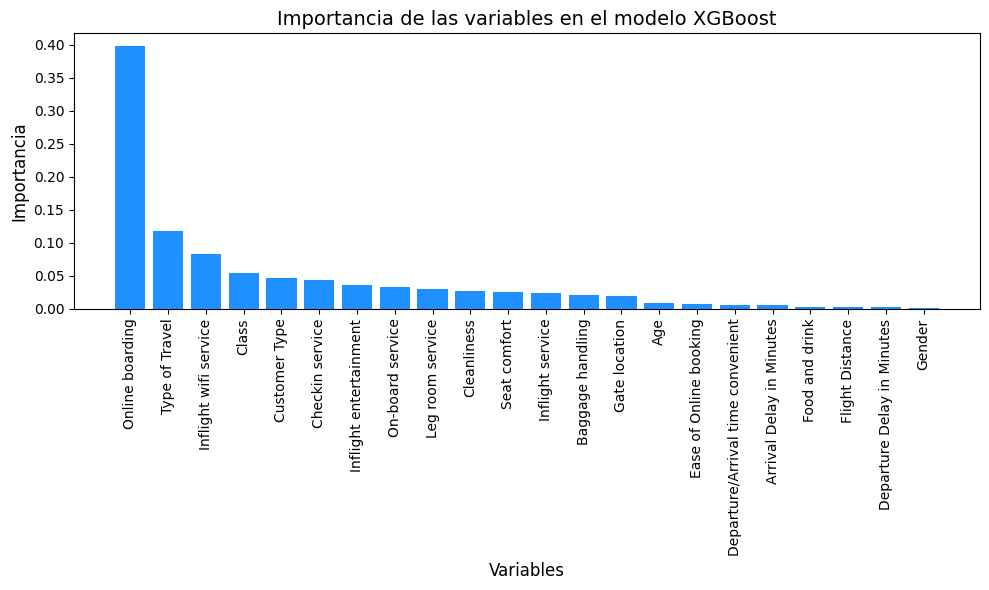

In [32]:
# Graficar las características ordenadas de mayor a menor
plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
plt.bar(importancia_df['Característica'], importancia_df['Importancia'], color='dodgerblue')
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Importancia", fontsize=12)
plt.title("Importancia de las variables en el modelo XGBoost", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotar las etiquetas del eje X
plt.tight_layout()  # Asegura que todo el gráfico se vea bien, sin etiquetas cortadas
plt.show()

